In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tnrange, tqdm_notebook, tqdm
import matplotlib.pyplot as plt

In [ ]:
mkdir data

In [17]:
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

0it [00:00, ?it/s]

9920512it [00:05, 1798284.25it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:01, 22081.02it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 1287532.35it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 15150.48it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Label: 5


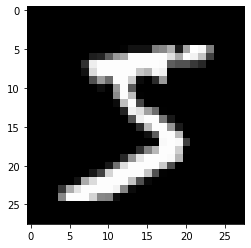

In [21]:
sample = next(iter(train_set))
image,label = sample #sequence unpacking
plt.imshow(image.squeeze(), cmap="gray")
print("Label:", label)

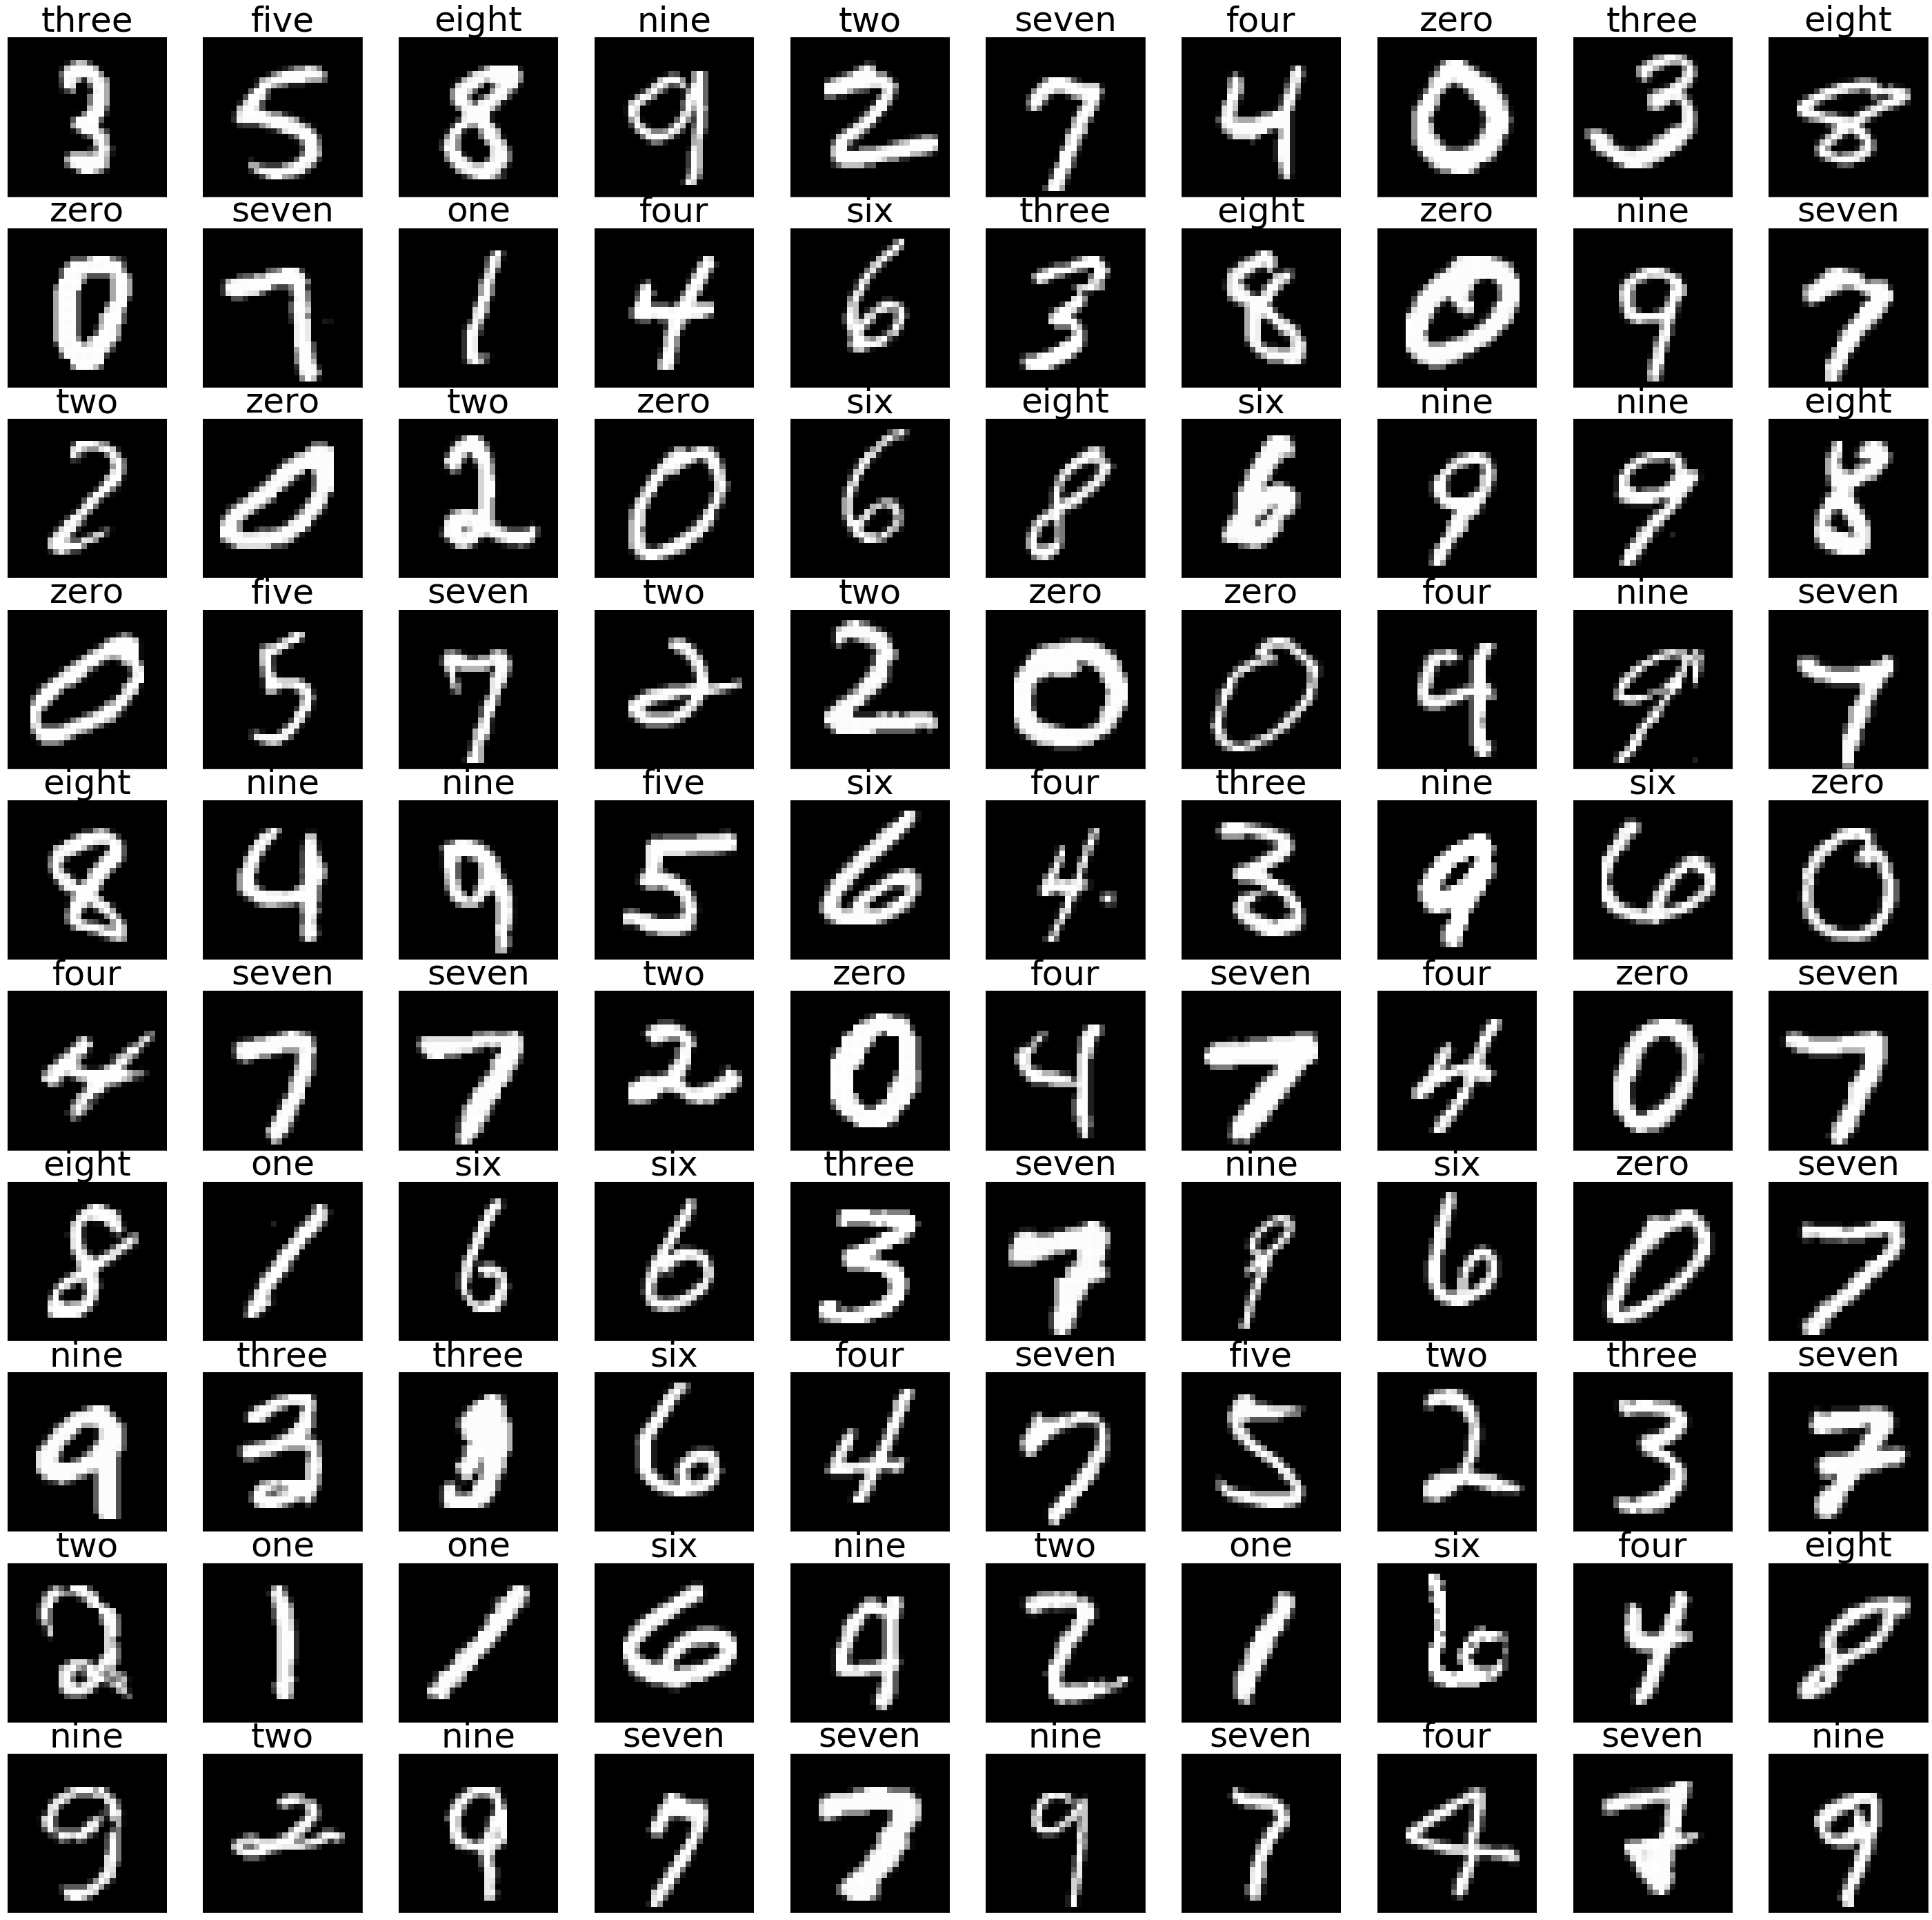

In [25]:
how_many_to_plot = 100

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

mapping = {
    0:'zero', 1:'one', 2:'two', 3:'three', 4:'four'
    ,5:'five', 6:'six', 7:'seven', 8:'eight', 9:'nine'
}

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    fig = plt.imshow(image.reshape(28,28), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(mapping[label.item()], fontsize=50)
    if (i >= how_many_to_plot): break
plt.show()

# prints 100 instances from the training data

In [31]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t=t
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        # 4,4 are height of each of the 12 output channels
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        

        return t

In [32]:
network=Network()

In [35]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)


In [41]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [42]:
loss_list=[]
acc_list=[]
for epoch in tnrange(10):
    

    total_loss = 0
    total_correct = 0

    for batch in tqdm_notebook(train_loader): # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
        
    )
    
    loss_list.append(total_loss)
    acc_list.append((total_correct)/60000)

/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



epoch 0 total_correct: 56043 loss: 122.6338142035529



epoch 1 total_correct: 58558 loss: 49.542235982604325



epoch 2 total_correct: 58736 loss: 43.41407274478115



epoch 3 total_correct: 58831 loss: 42.73465518618468



epoch 4 total_correct: 59000 loss: 36.33624540339224



epoch 5 total_correct: 59016 loss: 37.670199301850516



epoch 6 total_correct: 59035 loss: 37.09410309419036



epoch 7 total_correct: 59077 loss: 32.969396452012006



epoch 8 total_correct: 59115 loss: 34.797906616091495



epoch 9 total_correct: 59069 loss: 37.57514746036031



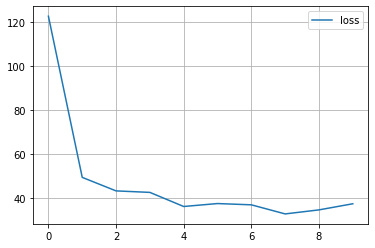

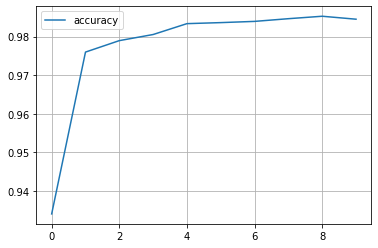

In [45]:
plt.plot(loss_list, label='loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(acc_list, label='accuracy')
plt.grid()
plt.legend()

In [46]:
torch.save(network.state_dict(), 'model_2.pt')

In [47]:
network.load_state_dict(torch.load('model_2.pt'))

<All keys matched successfully>

In [57]:
test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True #set this as true to download the data
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

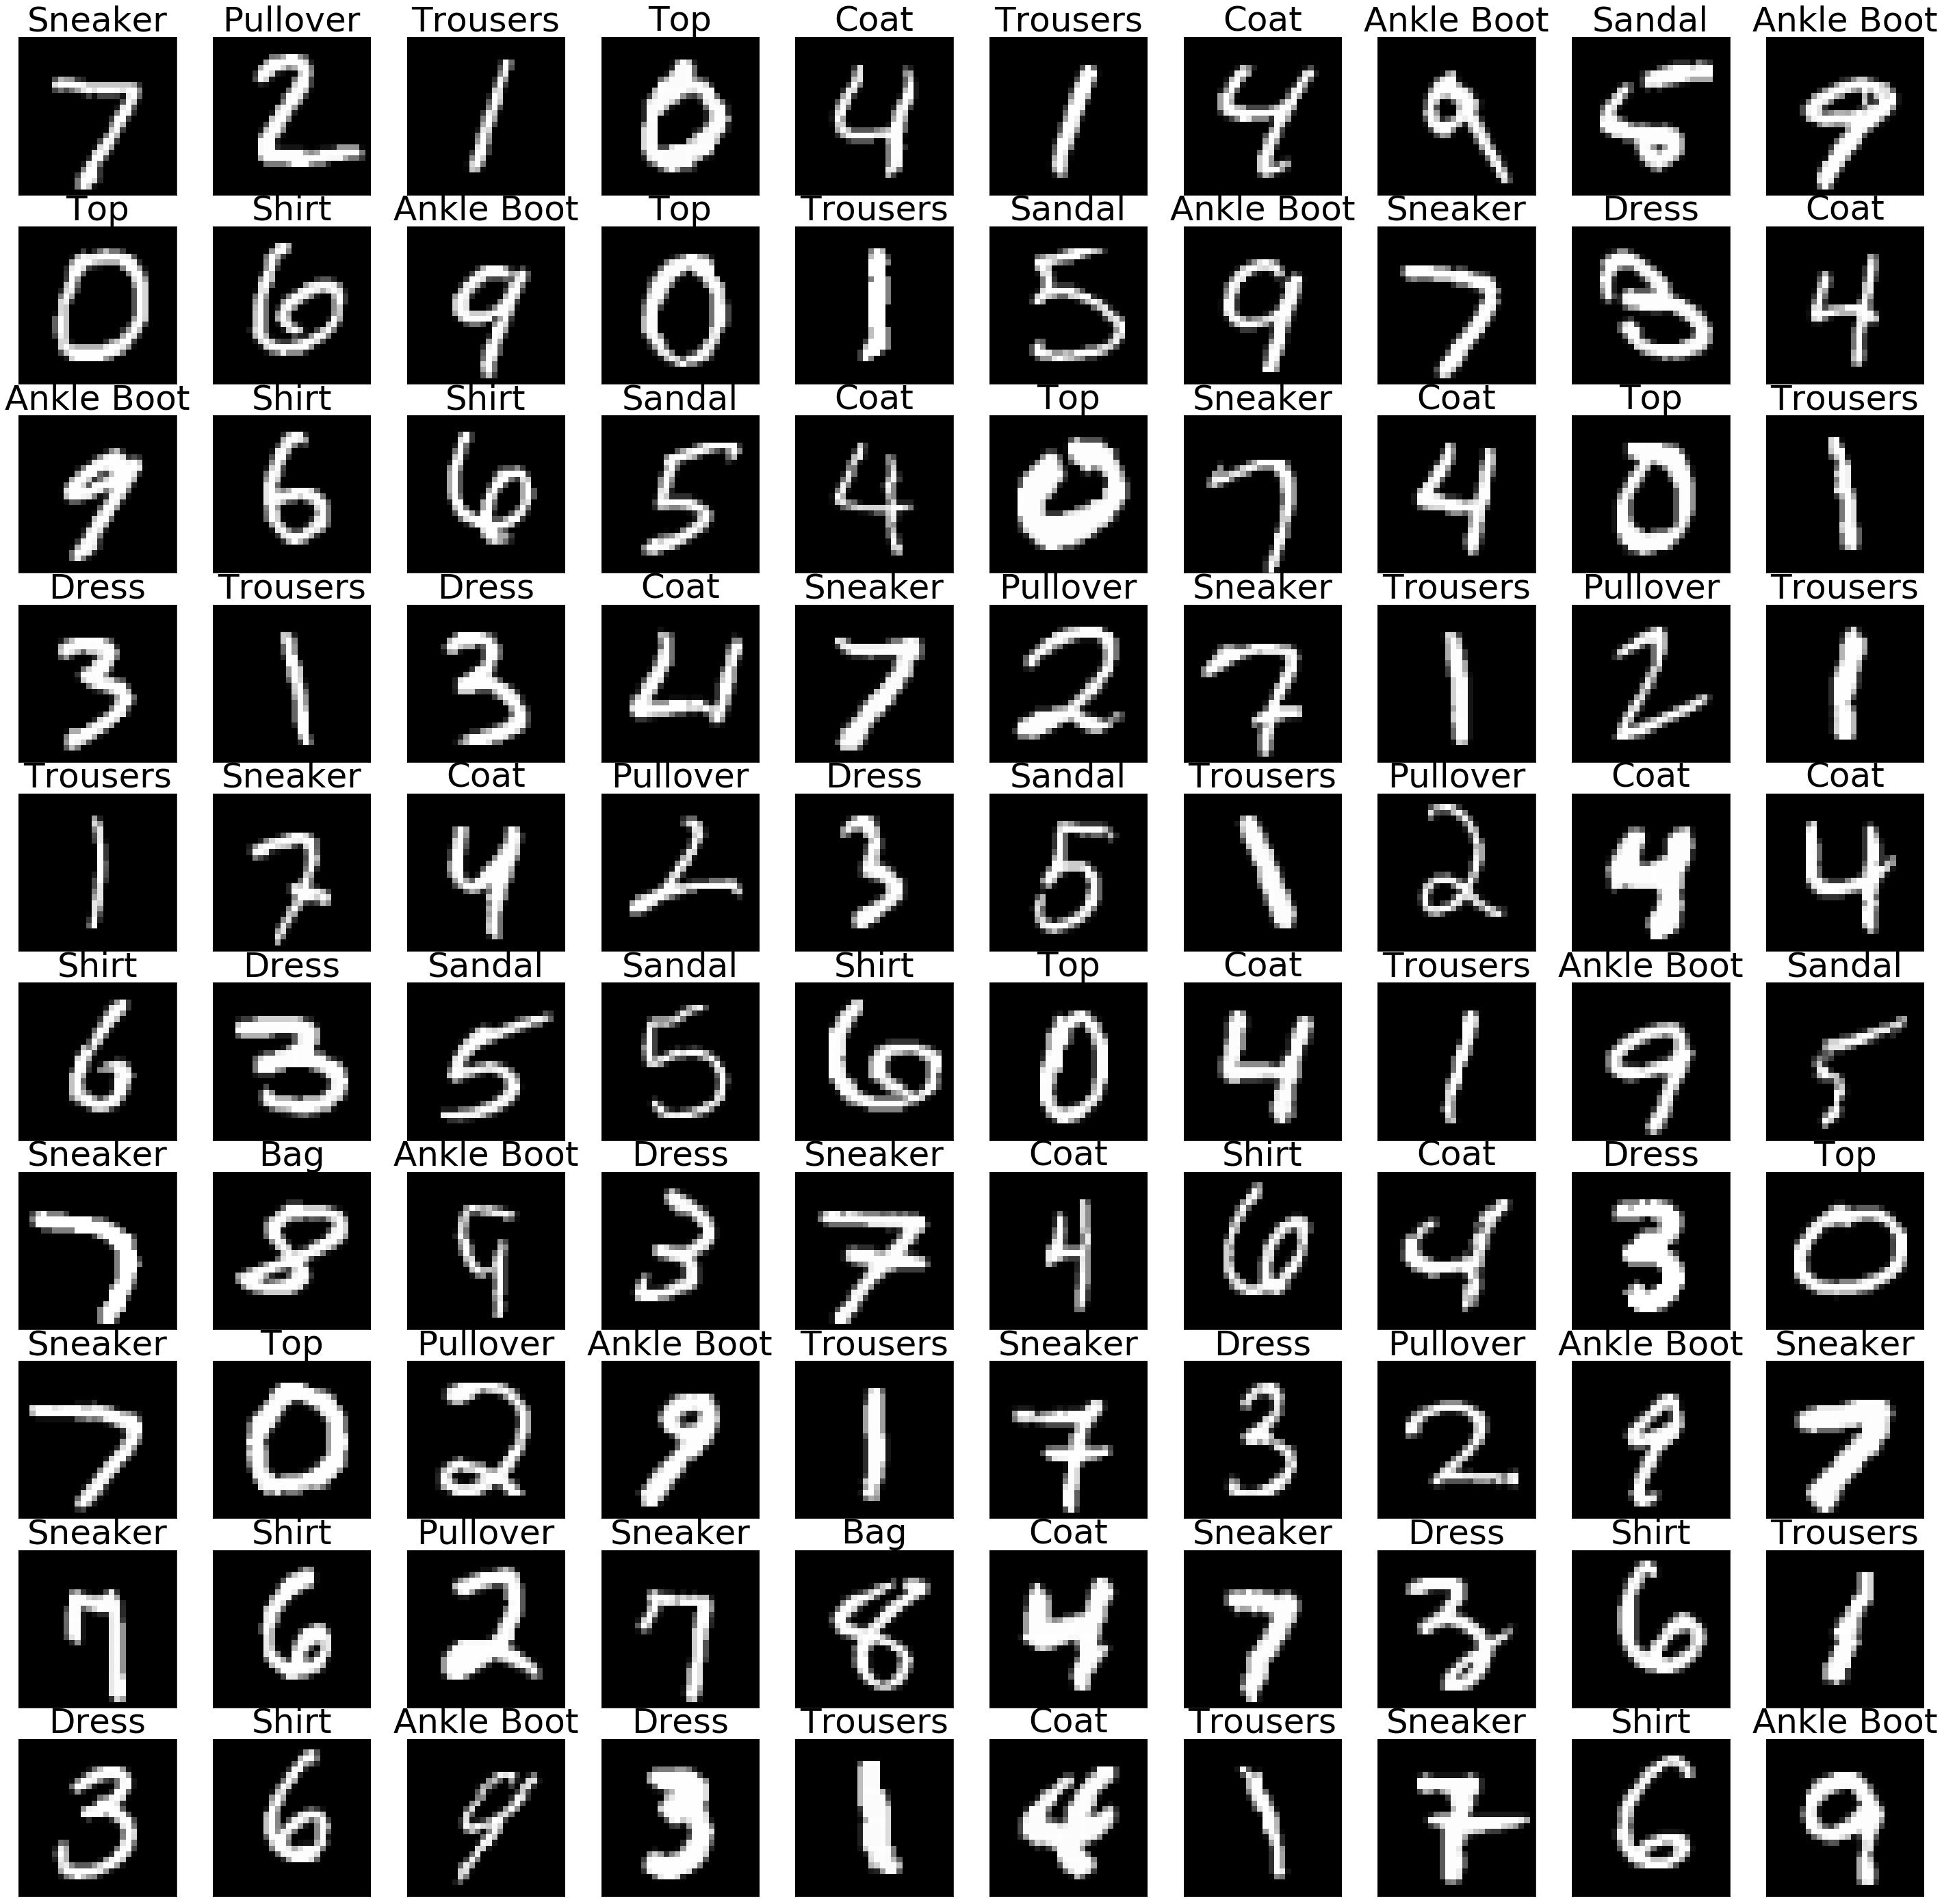

In [58]:
how_many_to_plot = 100

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1, shuffle=False
)

mapping = {
    0:'Top', 1:'Trousers', 2:'Pullover', 3:'Dress', 4:'Coat'
    ,5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'
}

plt.figure(figsize=(50,50))
for i, batch in enumerate(test_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    fig = plt.imshow(image.reshape(28,28), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(mapping[label.item()], fontsize=50)
    if (i >= how_many_to_plot): break
plt.show()

In [59]:
loss_list_2=[]
acc_list_2=[]
total_loss = 0
total_correct = 0

for batch in tqdm_notebook(test_loader): # Get Batch
    images, labels = batch 
    preds = network(images) # Pass Batch
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

    #print(
         
        #"total_correct:", total_correct
        
        
        
    #)
print(total_correct, "out of 10000.")
print("Which corresponds to", total_correct/100, "% accuracy.") 
    

/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



9823 out of 10000.
Which corresponds to 98.23 % accuracy.


In [61]:
# try augmentation
# split into train and val set, plot both